In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import KMeans
%matplotlib inline
import math as m
pd.set_option("display.precision", 8)

def indexlist(data,):
    '''use indeces to mark the 143 gps coordinates'''
    checklist = data['ref_x'].unique()
    for i in range(len(checklist)):
        data['point_index'] = data['point_index'].replace([checklist[i]],i)
    return data

def svm(rsrp,gps):
    X_train, X_test, y_train, y_test = train_test_split(value,label,
                                                    test_size=0.20,random_state=101)
    model = SVC(kernel='rbf', random_state=0, gamma = 0.01,C=100)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    #print(classification_report(y_test,prediction))
    pred = model.predict(X_test)
    accuracy = np.mean(pred == y_test)
    return np.array([pred]),np.array([y_test])


In [21]:
#read files
rsrp = pd.read_csv('rds-SRSRP.csv')
gps = pd.read_csv("gps.csv")
gps['coordinate'] =  list(zip(gps.ref_x, gps.ref_y))
#input indeces for each individual gps coordinates
gps['point_index'] = gps['ref_x']
gps = indexlist(gps)
checklist = pd.DataFrame(gps.coordinate.unique(),columns = ['coordinate'])

In [7]:
#pure SVM
#xtrain,ytrain,xlabel,ylabel = train_test_split(rsrp,gps['point_index'])
X_train, X_test, y_train, y_test = train_test_split(rsrp,gps['point_index'])
model = SVC(kernel='rbf', random_state=0, gamma = 0.01,C=100)
model.fit(X_train,y_train)
prediction = model.predict(X_test)
#print(classification_report(ylabel,prediction))

#grid search
parameters = {'kernel':('linear','rbf'),'C':[1,10]}
model1 = GridSearchCV(model,parameters)
model1.fit(X_train,y_train)
prediction1 = model.predict(X_test)
np.mean(prediction == y_test)

0.3969849246231156

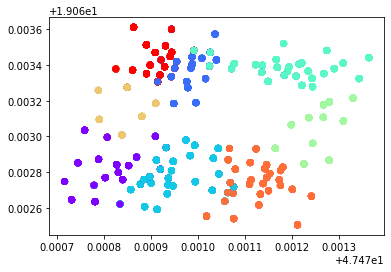

In [8]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(rsrp)
data = pd.concat([rsrp,gps[['ref_x','ref_y','point_index']]],axis = 1)
data['cluster'] = kmeans.labels_
plt.scatter(data.ref_x,data.ref_y,c=data.cluster,cmap='rainbow')

In [23]:
rsrp_raw = pd.read_csv('rds-SRSRP.csv').set_axis([0,1,2,3,4,5,6,7], axis=1)
rsrp['cluster'] = np.nan
cluster = []
for i in range(len(rsrp)):
    a = np.argmax(rsrp_raw.loc[i])
    cluster.append(a)
rsrp['cluster']= cluster

In [24]:
result = pd.DataFrame(columns = ['pred','test'])
feature = pd.concat([rsrp, gps['point_index']],axis = 1)
for i in range(8):
    data0 = feature[feature['cluster']==i]
    value = data0.iloc[:,:8]
    label = data0.iloc[:,-1]
    a,b = svm(value,data0)
    c = np.append(a,b,axis=0)
    result = result.append(pd.DataFrame(c.T,columns = ['pred','test']))

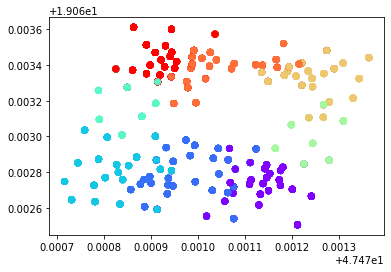

In [25]:
plt.scatter(gps.ref_x,gps.ref_y,c=feature.cluster,cmap='rainbow')

In [26]:
np.mean(result.pred == result.test)

0.4292114695340502

In [27]:
se_rec = []
pred = np.array(result.pred)
test = np.array(result.test)
for i in range(len(test)):
    y_ = int(test[i])
    y_p = int(pred[i])
    if y_ == y_p:
        se = 0
        se_rec.append(se)
    else:
        lon_pred, lat_pred = checklist.iloc[y_p][0]
        lon_, lat_ = checklist.iloc[y_][0]
        err_lon = lon_pred - lon_
        err_lat = lat_pred -lat_
        err_x = err_lon*((40000/360)*1000*m.cos(lat_pred))
        err_y = err_lat*((40000/360)*1000)
        se = err_x**2 + err_y**2
        se_rec.append(se)
        
rmse = np.sqrt(sum(se_rec)/len(test))
print("RMSE is {:.2f}m".format(rmse))
a = np.sqrt(se_rec)
b = np.sort(a)
print("When the accuracy is 80%,RMSE is {:.2f}m".format(b[int(len(a)*0.8)]))

RMSE is 9.23m
When the accuracy is 80%,RMSE is 11.31m
